This is my first notebook in quite a while, did some full-stack work as well as develop applications for a company. That has taken the majority of my time, I haven't been able to get back into machine learning for a little bit, hopefully some of my knowledge is still there, always excited to re-learn it, as the pathways are there, they just need to be refreshed.

Some things I've been up to:

- I started a new repo, one of my top full-stack applications, I called it buckles chat, after my pet cat.
  - https://github.com/cthacker-udel/BucklesChat
  - https://github.com/cthacker-udel/BucklesChatService
    - This was a very ambitious project, was a lot to take on, involved making an attempt at discord from scratch, using one of my most favorite frameworks [NextJS](https://nextjs.org/), and express for the backend. It was a lot to take on admittedly, I had to integrate 3 different databases into the application (Postgresql, MongoDB, Redis) and also integrate them all in nodejs without any hiccups. I had to finally tackle my avoidance of json web tokens, and it turned out to be extremely easy to implement, along with a full-fledged session library as well. This involved implementing complex middleware manually into the application. I used redis for managing user online status and also managing login throttling logic (which was fun to implement from scratch). This caused lots of time being devoted to developing because making this application was a blast. I had a moment where I completely refactored the structure of my database, involving switching all the foreign keys, and multiple column types as well. I used `sequelize` to handle all the postgres query generation, as doing that manually was difficult along with tedious when I could utilize an ORM to achieve the same functionality, those exist and are widely used (entity framework for example) I actually created a strong backend initially in C#, using ASP.Net core to achieve it, and it was working, but then I ran into the issue of figuring out how to deploy it, and that caused me to instantly transfer the entire backend to typescript using expressJS to handle all api functionality.
- Besides this project, I was moved from a project to head and complete an entire project on my own at work, without any assistance whatsoever, so that has been a challenge to complete and see it to the end. It involves RPA and C#, interesting work.

Besides all of that, let's get to our first notebook, processing HR competency scores used for screening.

## Dataset

Our dataset comprises of competency screening data for each candidate, which holds for example their years of experience, their top_1 skills score, their top2_behavior score, and whether they were called for an interview (most likely offered the job), this is actually something I can see being used in companies, and something that plays a role in lots of company's hiring processes.

In [245]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pprint import pprint
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [246]:
# Load in the dataset

hr_competency_screening_data = pd.read_csv('./dataset.csv')

hr_competency_screening_data.shape

# We have 300 rows to work with, so splitting will play a major factor in whether we over-train or under-train our model

(300, 10)

In [247]:
# Let's examine the columns datatypes

hr_competency_screening_data.dtypes

# It looks like we have majority float64 data type, and our target column is type integer

years_of_experience            float64
functional_competency_score    float64
top1_skills_score              float64
top2_skills_score              float64
top3_skills_score              float64
behavior_competency_score      float64
top1_behavior_skill_score      float64
top2_behavior_skill_score      float64
top3_behavior_skill_score      float64
call_for_interview               int64
dtype: object

In [248]:
# We can remove the target column and make a data tables of just the features (columns we are using to make the prediction)

target = hr_competency_screening_data['call_for_interview']

(target.head(), target.dtype)

# As you can see here, we got the correct column into the target variable, and the datatype matches up, int64.

(0    1
 1    0
 2    0
 3    0
 4    1
 Name: call_for_interview, dtype: int64,
 dtype('int64'))

In [249]:
# Now, let's compile the feature dataframe

potential_features = hr_competency_screening_data.drop(columns=['call_for_interview'])


(potential_features.columns, potential_features.shape)

# As you can see, having a shape of 300 rows and 9 columns means that we dropped the target column from the dataset

(Index(['years_of_experience', 'functional_competency_score',
        'top1_skills_score', 'top2_skills_score', 'top3_skills_score',
        'behavior_competency_score', 'top1_behavior_skill_score',
        'top2_behavior_skill_score', 'top3_behavior_skill_score'],
       dtype='object'),
 (300, 9))

Text(0.5, 1.0, "# of applicants' years of experience")

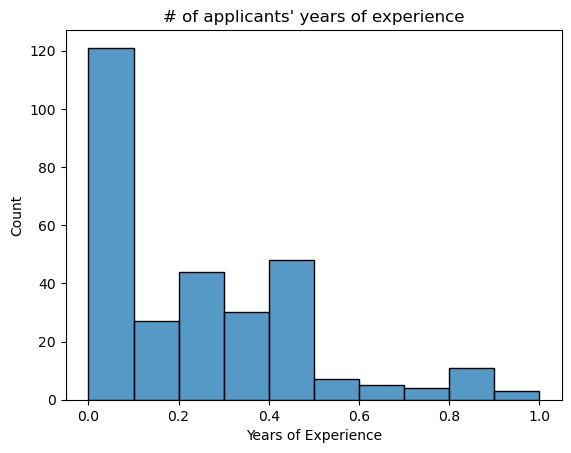

In [250]:
# Lets make a histogram of the frequency of years_of_experience

potential_features_axes = sns.histplot(potential_features['years_of_experience'], stat='count')

potential_features_axes.set_xlabel("Years of Experience")
potential_features_axes.set_ylabel("Count")
potential_features_axes.set_title("# of applicants' years of experience")

As we can see from this chart, the majority of applicants don't even have close to half a year of experience, so that will be a major contributing factor into our predictions, also, there seems to be a major cutoff when the years of experience hit 0.5 (aka half a year), so maybe we could group all values >= 0.5 into one category to maybe balance out the proportions, let's try that out.

In [251]:
potential_features['expert_years_of_experience'] = potential_features['years_of_experience'].map(lambda x: x >= 0.5)

expert_years = potential_features[potential_features['expert_years_of_experience'] == True]
non_expert_years = potential_features[potential_features['expert_years_of_experience'] == False]

percentage_of_experts = (expert_years.shape[0] + non_expert_years.shape[0]) / expert_years.shape[0]

f'{percentage_of_experts}% of the applicants have more then half a year of experience'

'10.0% of the applicants have more then half a year of experience'

The fact that only 10% of applicants in this dataset have more then half a year of experience shows either a desirability, or a scarcity, as most of the people did not have the proper experience for the job. This paints an interesting picture in this small dataset. It is mostly comprised of people who did not have a lot of experience with the skills required for this job, and they applied anyway. As we dig more into this dataset, we can explore maybe how they managed when recruiting/deciding whether to hire people with more then half a year of relative experience. Let's graph the frequency of that small subset into another histogram.

Text(0.5, 1.0, '# of applicants with >= .5 years of experience')

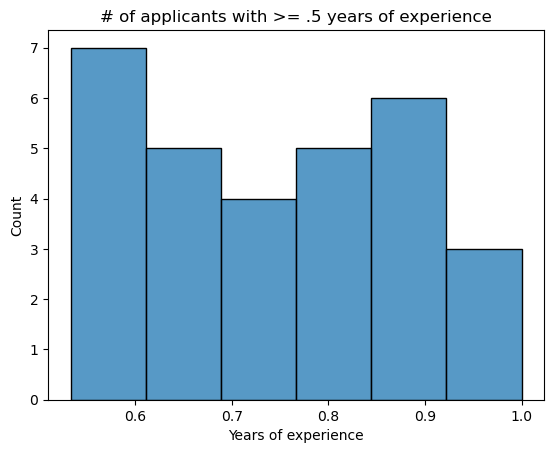

In [252]:
axes = sns.histplot(expert_years['years_of_experience'], stat='count')
axes.set_xlabel("Years of experience")
axes.set_ylabel("Count")
axes.set_title("# of applicants with >= .5 years of experience")

This histogram gives us a good idea of the count of each of the years of experience among the small 10% subset that has half or more of a year of experience. There seems to be barely any applicants that have a year of experience, only about 3 out of the 300 applicants had a full year of experience. This puts into perspective really how absurd the assumption is that everyone applying for a job has all the qualifications completely satisfied. The majority of applicants seem to have a range from 0.5 --> 0.69 and 0.76 --> 0.92. We can sate that the small dip in the graph is relatively a small part of the totality of the graph (only about 0.05 years)

Now, lets observe how the applicants with >= 0.5 years of experience fared in the assessments, we'll make a simple bar chart for the functional competency scores, then compare that against all the applicants with < 0.5 years of experience, let's see the results!

c:\Users\flyin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Applicants >= .5 year experience functional competency score')

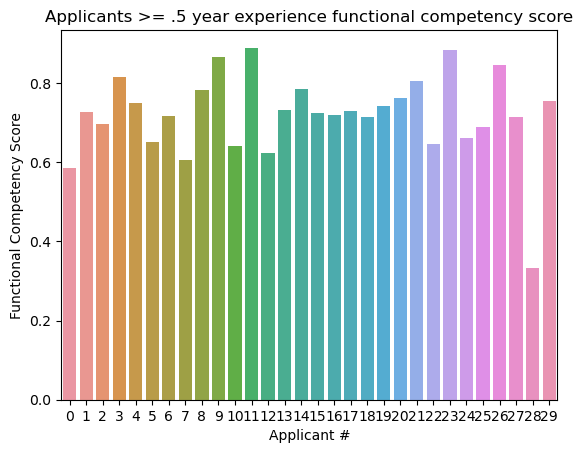

In [253]:
number_of_people_greater_than_half_year_experience = expert_years.shape[0]

axes = sns.barplot(np.arange(0, number_of_people_greater_than_half_year_experience), expert_years['functional_competency_score'])
axes.set_xlabel("Applicant #")
axes.set_ylabel("Functional Competency Score")
axes.set_title("Applicants >= .5 year experience functional competency score")

It appears as though most of the applicants who listed their years of experience as over half a year did about average on the functional competency test, there are a few outliers for example, one of the applicants scored incredibly low on the test, scoring a ~.35 (35%) on the test, let's compute the average to get a good idea.

In [254]:
round(np.average(expert_years['functional_competency_score']), 2)

0.72

As we can see from the average, the average score among the applicants with years of experience >= .5 was about 72%

In [255]:
round(np.average(non_expert_years['functional_competency_score']), 2)

0.56

As we can see from this average as well, that most of the applicants with < 0.5 years of experience scored a little bit lower then those with more experience, which was expected. Let's look at a chart of their scores. Since we have a considerable amount of data, we can't use a bar chart, we can use a scatter plot however, because we have 270 data points versus the 30 pictured above.

c:\Users\flyin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Applicants < .5 year experience functional competency score')

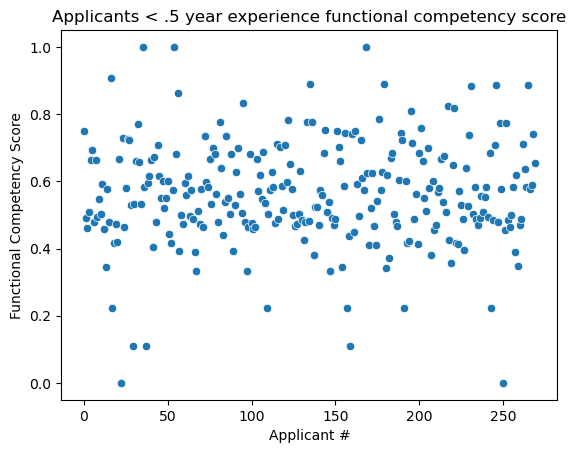

In [256]:
axes = sns.scatterplot(np.arange(0, non_expert_years.shape[0]), non_expert_years['functional_competency_score'])
axes.set_xlabel('Applicant #')
axes.set_ylabel("Functional Competency Score")
axes.set_title("Applicants < .5 year experience functional competency score")

As we can see from the scatter plot, we have some applicants that scores 0.0 out of 1 on the test, and some that scored 100 on the test. Although the average is clustered in-between 0.4 and 0.8. Let's see how the average changes when we remove these outliers.

c:\Users\flyin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Applicants < 0.5 year experience with outliers removed functional competency score')

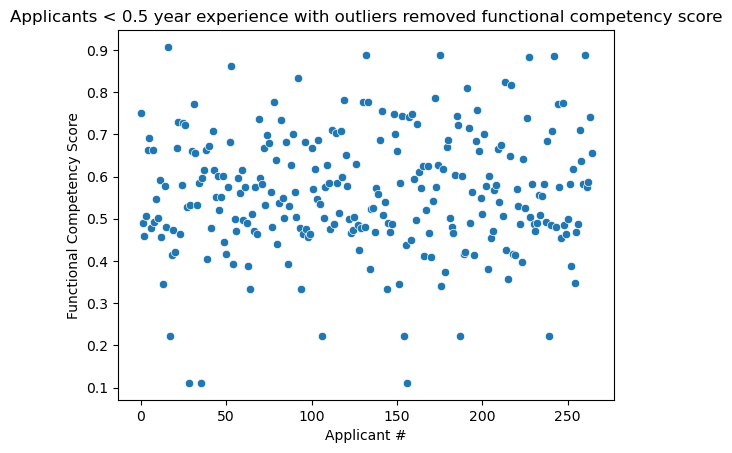

In [257]:
new_non_expert_years = non_expert_years[non_expert_years['functional_competency_score'].gt(0.0) & non_expert_years['functional_competency_score'].lt(1.0)]

axes = sns.scatterplot(np.arange(new_non_expert_years.shape[0]), new_non_expert_years['functional_competency_score'])
axes.set_xlabel("Applicant #")
axes.set_ylabel("Functional Competency Score")
axes.set_title("Applicants < 0.5 year experience with outliers removed functional competency score")

This scatter plot is looking to be more clustered then the original,  where we had outliers in the bottom-right and top-left of the chart, now we may have a good set of data to work with for all users with years < 0.5 years of experience.

In [258]:
## Lets see how many values we stripped out with that filter operation above

non_expert_years.shape[0] - new_non_expert_years.shape[0], round(((non_expert_years.shape[0] - new_non_expert_years.shape[0]) / non_expert_years.shape[0]) * 100, 2)

(5, 1.85)

As you can see, we only took out a total of 5 values from that filter, which comprises of only 1.85% of the original dataset, a very very small subset, so stripping our dataset of those values did not have any negative effects on our prediction.

In [259]:
## Let's see if we can compute the # of unique values in this non expert dataset

new_non_expert_years['functional_competency_score'].describe(), '^^^^ FILTERED ^^^^', 'vvvv NON-FILTERED vvvv', non_expert_years['functional_competency_score'].describe()

(count    265.000000
 mean       0.561959
 std        0.139593
 min        0.111111
 25%        0.477887
 50%        0.557987
 75%        0.662020
 max        0.907100
 Name: functional_competency_score, dtype: float64,
 '^^^^ FILTERED ^^^^',
 'vvvv NON-FILTERED vvvv',
 count    270.000000
 mean       0.562664
 std        0.153660
 min        0.000000
 25%        0.477827
 50%        0.559357
 75%        0.662618
 max        1.000000
 Name: functional_competency_score, dtype: float64)

Observing this describe of our current filtered dataset, we can see that the standard deviation is not that insane, the data only differs from the mean about an average of 10% on their test score, which isn't the most insanely unbalanced statistic to see, while our mean is an average of .56, let's describe the expert years subset to see their difference.


Edit: after adding in the describe of our original dataset, we can see that the mean did not vary at all, it only changed by .00705, which is a tiny value, so removing that data from our dataset did not have a heavy influence on the overlying pattern of the data, but we have yet to analyze the repercussions on the other columns, but as we can see it did not change functional score that much. The only slight increase is the standard deviation, which increased by .02, meaning that with the outliers the data was more spread out, which makes sense.

In [260]:
expert_years['functional_competency_score'].describe()

count    30.000000
mean      0.719522
std       0.107315
min       0.333333
25%       0.666967
50%       0.725142
75%       0.778228
max       0.888889
Name: functional_competency_score, dtype: float64

Dissecting this describe for the functional competency score of all users who said they have >= .5 years of experience, we can see that the mean of the applicants with >= .5 years of experience have test scores averaging about .71/.72 compared, to the applicants with less than .5 years of experience, who have ~.5 average score on the functional test. We can also observe that the standard deviation is less with the more experienced individuals, which means that their test scores are more closely grouped together, meaning there not so many outliers as in the dataset of users with < .5 years of experience, this is expected as it's generally less data in the expert dataset versus the non-expert dataset.

Let's start creating some models to try to predict whether they will receive a call back or not, we've done an analysis on one of the columns of the data, so let's begin with that.

We could approach this problem with simple linear regression, so let's try to make a linear regression model.

In [261]:
linear_expert_model = LinearRegression()

target_variables = [hr_competency_screening_data.loc[x]['call_for_interview'] for x in expert_years.axes[0]]

train_x, validation_x, train_y, validation_y = train_test_split(expert_years, target_variables, test_size=.2, random_state=1)

linear_expert_model.fit(train_x, train_y)

linear_expert_model.score(validation_x, validation_y)

1.0

As we can see, the score is perfect, because all the rows with experience >= .5 years always gets a call back, so that can be predicted without a model. No matter how we tune the parameters, it will give us the same result for any entry that has it's years of experience >= .5.

As we can see, the average of all the expert years, even though some of them scored as well as the applicants that did not have as much experience, were always asked for an interview with the company, this plays an important role. As we drive the analysis deeper into the data, let's see the averages of all of the columns to get a better understanding of the differences between the two groups, more experience vs less experience.

Index(['years_of_experience', 'functional_competency_score',
       'top1_skills_score', 'top2_skills_score', 'top3_skills_score',
       'behavior_competency_score', 'top1_behavior_skill_score',
       'top2_behavior_skill_score', 'top3_behavior_skill_score',
       'expert_years_of_experience', 'is_experienced'],
      dtype='object')


Text(0.5, 0, 'Is Experienced')

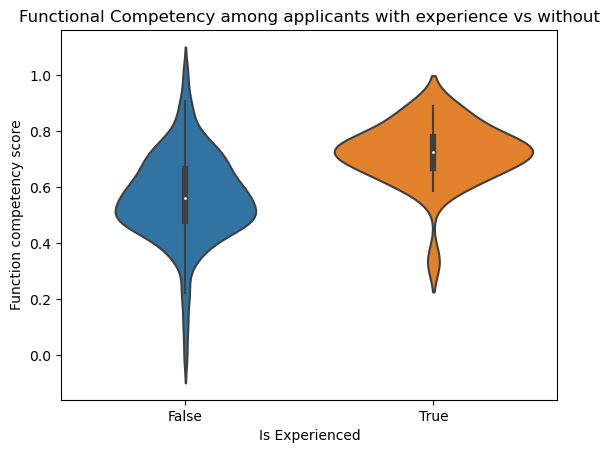

In [262]:
modified_hr_data = potential_features.copy()
modified_hr_data['is_experienced'] = modified_hr_data['years_of_experience'].ge(.5)

print(modified_hr_data.columns)


fcs_axes = sns.violinplot(data=modified_hr_data, x='is_experienced', y='functional_competency_score')
fcs_axes.set_title('Functional Competency among applicants with experience vs without')
fcs_axes.set_ylabel("Function competency score")
fcs_axes.set_xlabel("Is Experienced")

As we can observe from this chart, the experienced applicants scores were mostly slightly above those that were not experienced (< .5 years of experience), therefore we can make the assumption that those experienced scored generally higher on the functional competency part of the application process. Although, those with experience were not able to achieve a perfect score, while those without experience were able to achieve that feat, as well on the flip side able to achieve a 0.0 score.

Text(0.5, 1.0, 'Experienced vs. Non-Experienced scores on Test 1')

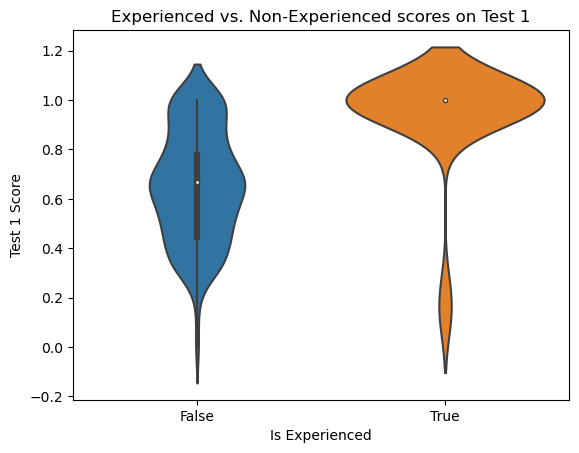

In [263]:
tss1_axes = sns.violinplot(data=modified_hr_data, x='is_experienced', y='top1_skills_score')
tss1_axes.set_ylabel("Test 1 Score")
tss1_axes.set_xlabel("Is Experienced")
tss1_axes.set_title("Experienced vs. Non-Experienced scores on Test 1")

As we can see from this chart, the majority of applicants with experience scored highly on the first test, while there were a few outliers. For the applicants that were not experienced, we can see that they had more of a wide range of scores on the first test.

Text(0, 0.5, 'Behavioral Test 1 Score')

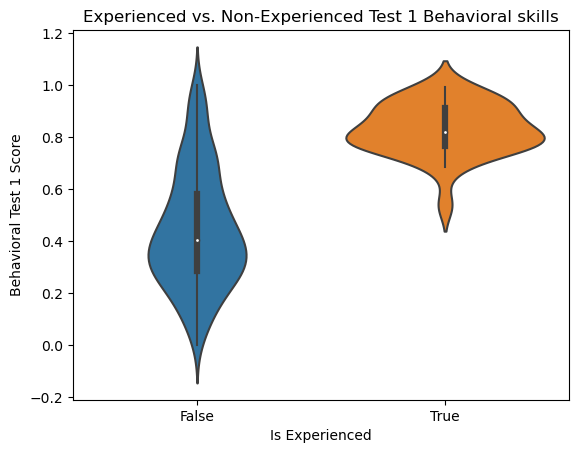

In [264]:
tss1b_axes = sns.violinplot(data=modified_hr_data, x='is_experienced', y='top1_behavior_skill_score')
tss1b_axes.set_title("Experienced vs. Non-Experienced Test 1 Behavioral skills")
tss1b_axes.set_xlabel("Is Experienced")
tss1b_axes.set_ylabel("Behavioral Test 1 Score")

As we can see from this chart, when it came to behavior analysis, we can clearly see a distinction between those that had more experience versus those that had less. Those who had experience score overwhelmingly low, none reaching near the failure mark. While those without experience ranged evenly throughout all possible scores.

Text(0.5, 1.0, 'Experienced vs Non-Experienced | Top 2 Skills Score')

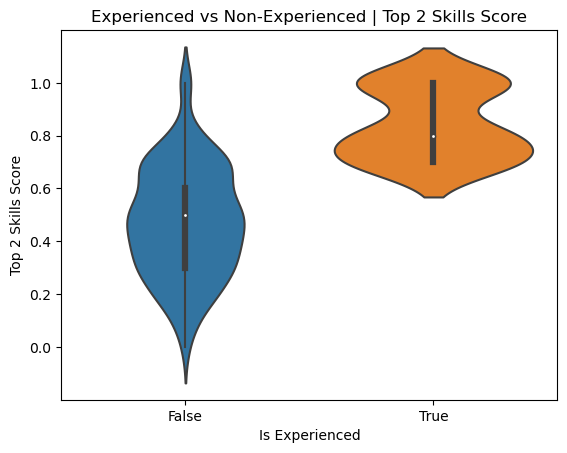

In [265]:
tss2_axes = sns.violinplot(data=modified_hr_data, x='is_experienced', y='top2_skills_score')
tss2_axes.set_xlabel("Is Experienced")
tss2_axes.set_ylabel("Top 2 Skills Score")
tss2_axes.set_title("Experienced vs Non-Experienced | Top 2 Skills Score")

As we can see from this chart, those that have higher experienced scored considerably higher then those with no experience according to this chart, the majority scoring >= 0.6, while those without experience, their scores ranging generally from very high to very low.

c:\Users\flyin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.65

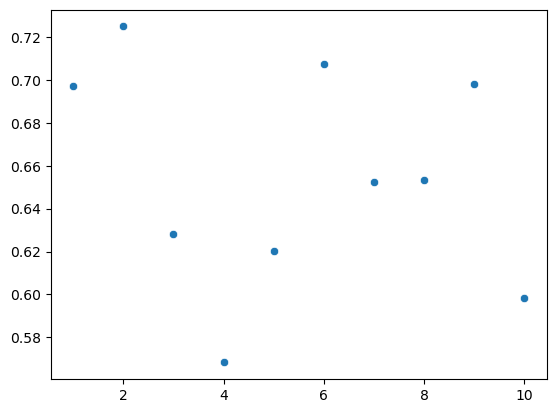

In [266]:
# We have seen enough trends to make a model, we expect those with lower # of experience to score generally in different
# ranges then those with more experience. But those with experience are more used to the experience so they don't typically
# have exceptionally high or exceptionally low scores, but generally average above the mean of the applicants with low experience.

# Let's test it out with linear regression

full_linear_model = LinearRegression()

scores = []
test_number = []
for i in range(10):
    train_x, test_x, train_y, test_y = train_test_split(potential_features, target, test_size=.35)
    full_linear_model.fit(train_x, train_y)
    score = full_linear_model.score(test_x, test_y)
    test_number.append(i + 1)
    scores.append(score)

sns.scatterplot(test_number, scores)
round(np.average(scores), 2)

As you can see, linear regression may not be the best choice for us when trying to predict these values, we can see the average of the predictions is around 60/70%, which is not bad but at the same time it is not good, we want a high 80/90%. So this leaves us to perhaps choose logistic regression or other models, and see how those perform.

Lets try `ridge regression`, it can reduce the variance of our model hopefully and allow for higher scores when we collect the score from the predictions. It adds a penalty to the squared residuals, which comprises of `lambda * all parameters squared`.

c:\Users\flyin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.66

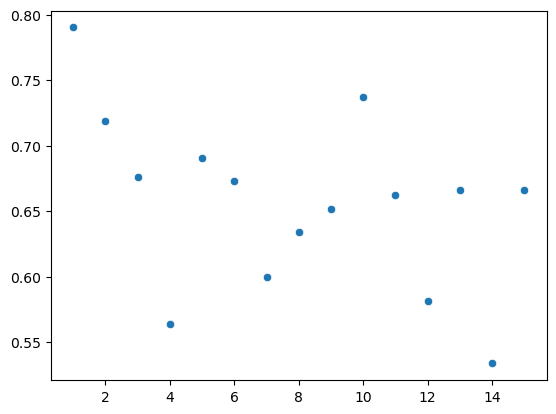

In [267]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

scores = []
test_number = []
for i in range(15):
    train_x, test_x, train_y, test_y = train_test_split(potential_features, target)
    ridge_model.fit(train_x, train_y)
    scores.append(ridge_model.score(test_x, test_y))
    test_number.append(i + 1)

sns.scatterplot(test_number, scores)
round(np.average(scores), 2)

Observing this graph, we can see that the highest prediction goes up to .80, which is a major improvement from the highest in the previous lesser squares model being low .70s, but still, the average prediction is only slightly better then the previous lesser squares model.

Perhaps we should try logistic regression, due to the nature of the problem being a classifier problem, whether the applicant is called (1) or not called (0), instead of trying to predict a continuous value, we want to predict a discrete value, therefore we may want to try logistic regression on this dataset to try to predict whether an applicant is called (1) or not (0)

c:\Users\flyin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.9126666666666667

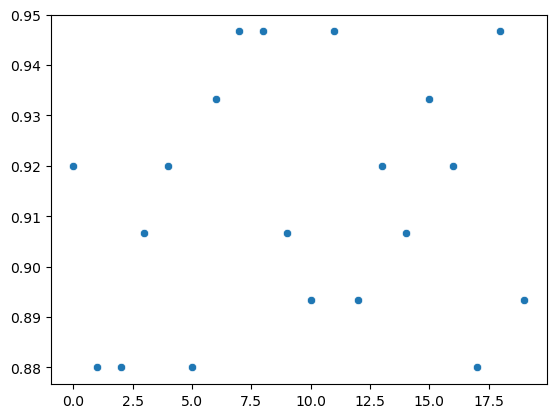

In [309]:
# importing logistic regression model
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
scores = []
test_number = []

for i in range(20):
    train_x, test_x, train_y, test_y = train_test_split(potential_features, target)
    logistic_model.fit(train_x, train_y)
    scores.append(logistic_model.score(test_x, test_y))
    test_number.append(i)

sns.scatterplot(test_number, scores)
np.average(scores)

# WOW!

Logistic regression absolutely hits linear regression out of the park, scoring an average of .90 for it's prediction score, this was the correct approach and one I should take in the future when working on problems that involve predicting a discrete value rather then a continuous value. I still need to learn hyper-parameter tuning to further increase this prediction score, but wow, I was not expecting that high of a score, and am honestly shocked. That is an excellent score! Time to present my findings.

I have constructed a linear regression model, that predicts, given the scores the applicant achieves on the assessments, whether they will receive an interview call back from the company. This plays a pivotal role in recruitment and also job seekers who want to know what the most optimal scores are to achieve on the assessments for this company to get a call for an interview back. I started off trying to solve it with linear regression, which wasn't quite the solution I was hoping for, as it only had a score of .70, and wasn't quite fitting with the relationship of the data, which was most likely not in a linear line, and curved in nature. I then tried ridge regression, which led to a little bit of a higher score compared to my linear regression, but it wasn't quite a drastic improvement, only about .71/.72 average. I decided to try linear regression then, as it seemed most fit for the dataset + the problem at hand, which was predicting whether a user would receive a call back from the recruiter with the results of their test assessment scores. That model ended up working perfectly and scored a high ~.91 score, which was more then what I expected, I will settle for this model as my final result, and leave the findings + charts as a history of my discovery process figuring out how to predict this data accurately. This was my first time back into machine learning after a brief hiatus doing full-stack work along with working full-time at my current job. Went very well and I am very satisfied with the outcome of this welcome back exercise.